# Imports 

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Loading Data and Preprocessing

In [15]:
df = pd.read_csv('student-por.csv', delimiter=';')


In [25]:
df.shape


(649, 33)

In [17]:
df = df.replace({'Mjob': {'at_home': 0, 'teacher': 1, 'services': 2, 'health': 3, 'other': 4}})
df = df.replace({'G3': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}})
df = df.replace({'G3': {10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1}})



In [18]:
df.head()


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,0,teacher,...,4,3,4,1,1,3,4,0,11,1
1,GP,F,17,U,GT3,T,1,1,0,other,...,5,3,3,1,1,3,2,9,11,1
2,GP,F,15,U,LE3,T,1,1,0,other,...,4,3,2,2,3,3,6,12,13,1
3,GP,F,15,U,GT3,T,4,2,3,services,...,3,2,2,1,1,5,0,14,14,1
4,GP,F,16,U,GT3,T,3,3,4,other,...,4,3,2,1,2,5,0,11,13,1


In [19]:
from sklearn.model_selection import GridSearchCV

feature_cols = ['G1', 'G2', 'absences', 'Mjob', 'goout']
# feature_cols = ['G1','G2','Mjob']
# feature_cols = ['G2']


X = df[feature_cols]
y = df['G3']


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=649-40)


## Decision Tree

In [44]:
def fit_and_plot_classification(model, trainData, feature_names, target_names):
    model.fit(data[feature_names], data[target_names])
    if data[target_names].nunique() == 2:
        palette = ["tab:red", "tab:blue"]
    else:
        palette = ["tab:red", "tab:blue", "black"]
    DecisionBoundaryDisplay.from_estimator(
        model, trainData, response_method="predict",
        cmap="RdBu", alpha=0.5
    )
    sns.scatterplot(data=data, x=feature_names[0], y=feature_names[1],
                    hue=target_names, palette=palette)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

dt = DecisionTreeClassifier(criterion='gini', max_depth=2)

# dt.fit(X_train, y_train)

# y_pred = dt.predict(X_test)
# print(classification_report(y_pred, y_test))

In [13]:
from interpret.blackbox import LimeTabular
from interpret import show

lime = LimeTabular(model=dt, 
                   data=X_train, 
                   random_state=1)

In [14]:
lime_local = lime.explain_local(X_test[-30:],
                               y_test[-30:],
                               name='LIME')
show(lime_local)

<!-- http://127.0.0.1:7787/1968932438224/ -->

### Results for Feature Set 1:

Optimal Hyperparameters -> criterion='gini', max_depth=2

Classification Report (weighted avg) -> precision=0.93, recall=0.92, f1=0.92

### Results for Feature Set 2

Optimal Hyperparameters -> criterion='gini', max_depth=2

Classification Report (weighted avg) -> precision=0.92, recall=0.91, f1=0.91

### Results for Feature Set 3

Optimal Hyperparameters -> criterion='gini', max_depth=default

Classification Report (weighted avg) -> precision=0.93, recall=0.92, f1=0.92

In [11]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

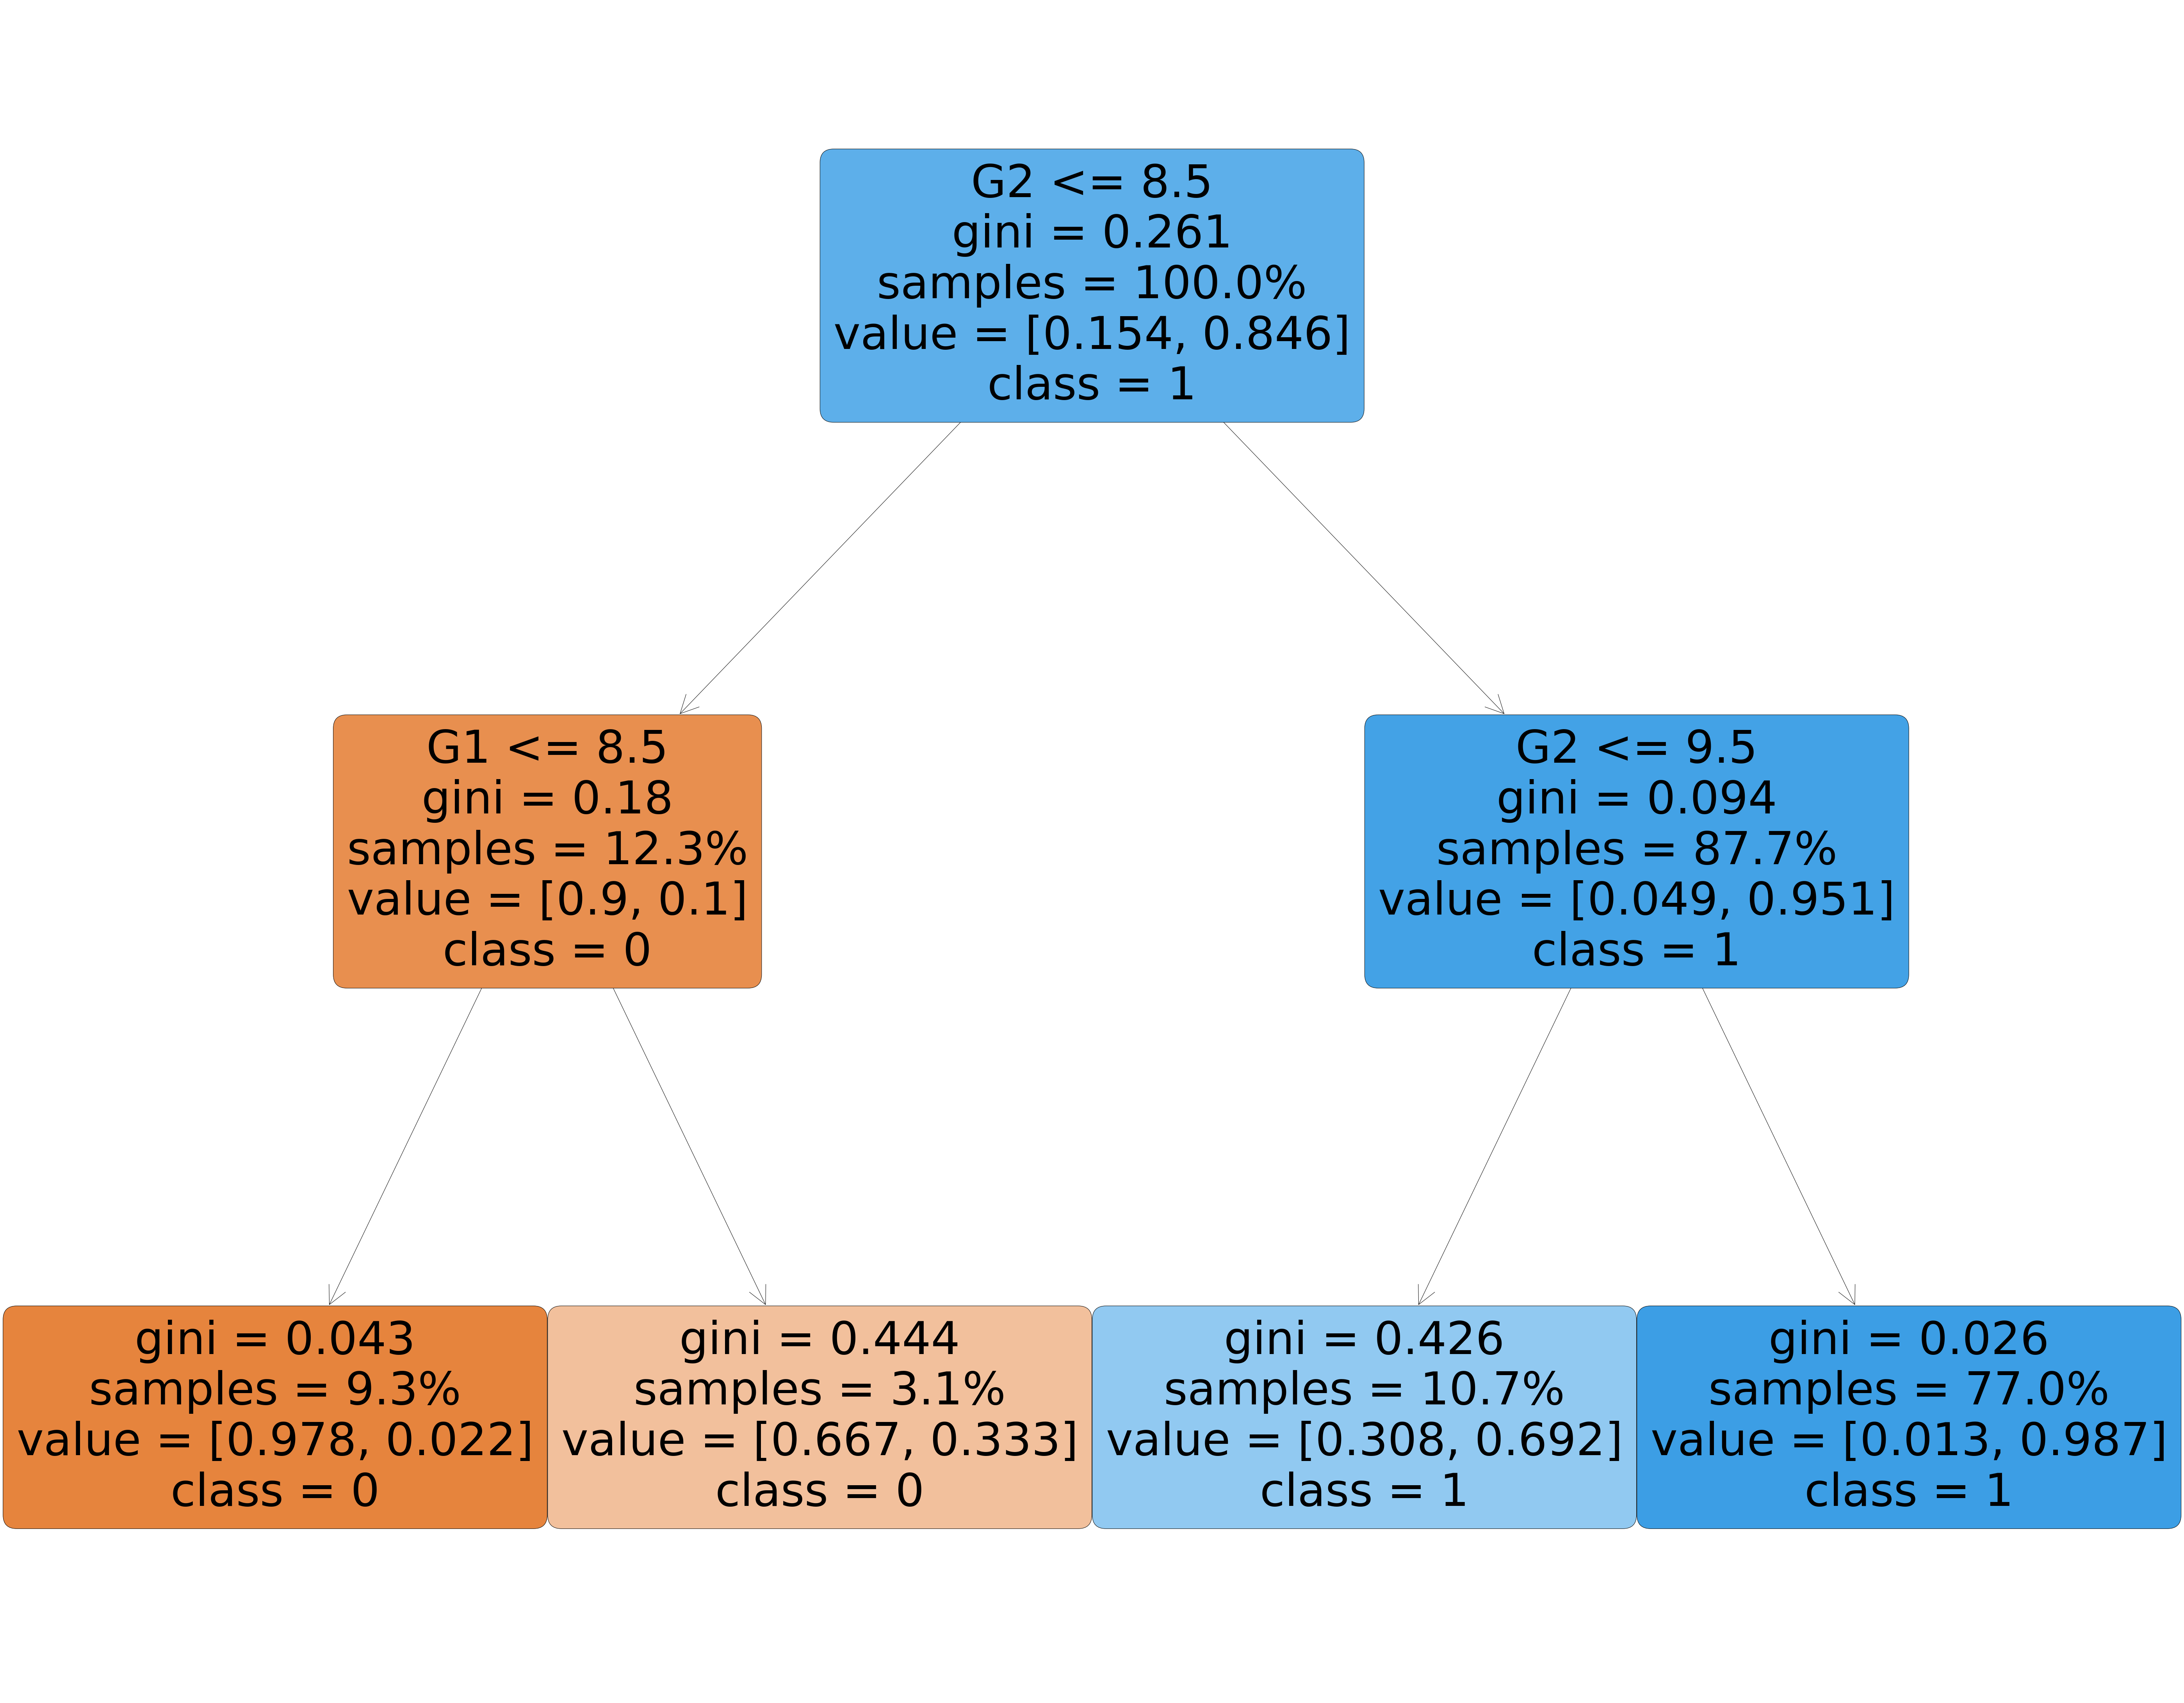

In [12]:
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt
plt.figure(figsize=(100, 80))
plot_tree(dt,
          feature_names=feature_cols,
          class_names=['0','1'],
          rounded=True, # Rounded node edges
          filled=True, # Adds color accoding to class
          proportion=True)
plt.show()

### Tree Structure

In [149]:
n_nodes = dt.tree_.node_count
children_left = dt.tree_.children_left
children_right = dt.tree_.children_right
feature = dt.tree_.feature
threshold = dt.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 7 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 1] <= 8.5 else to node 4.
	node=1 is a split node: go to node 2 if X[:, 0] <= 8.5 else to node 3.
		node=2 is a leaf node.
		node=3 is a leaf node.
	node=4 is a split node: go to node 5 if X[:, 0] <= 9.5 else to node 6.
		node=5 is a leaf node.
		node=6 is a leaf node.


### Decision Path 

In [157]:
dt.tree_.impurity[5]

0.39907582440663725

## Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=3)

# rf.fit(X_train, y_train)
# y_pred_2 = rf.predict(X_test)


In [54]:
print(metrics.classification_report(y_test, y_pred_2))
print(metrics.confusion_matrix(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.81      0.57      0.67        23
           1       0.93      0.98      0.95       140

    accuracy                           0.92       163
   macro avg       0.87      0.77      0.81       163
weighted avg       0.92      0.92      0.91       163

[[ 13  10]
 [  3 137]]


In [55]:
rf.feature_importances_

array([0.34829534, 0.5929009 , 0.02508084, 0.01230519, 0.02141773])

Built-In Feature Importance 

Text(0.5, 0, 'Random Forest Feature Importance')

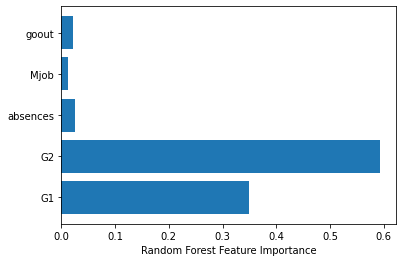

In [56]:
plt.barh(feature_cols, rf.feature_importances_)
plt.xlabel("Random Forest Feature Importance")

Permutation Based Feature Importance

In [59]:
from sklearn.inspection import permutation_importance 

perm_importance = permutation_importance(rf, X_test, y_test)


Text(0.5, 0, 'Random Forest Feature Importance')

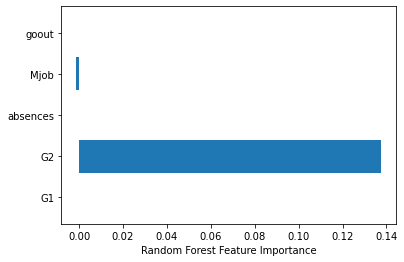

In [60]:
plt.barh(feature_cols, perm_importance.importances_mean)
plt.xlabel("Random Forest Feature Importance")

SHAP Feature Importance

In [61]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)


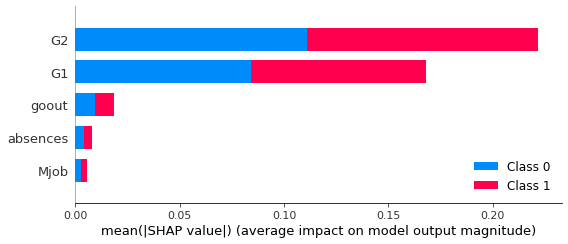

In [62]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


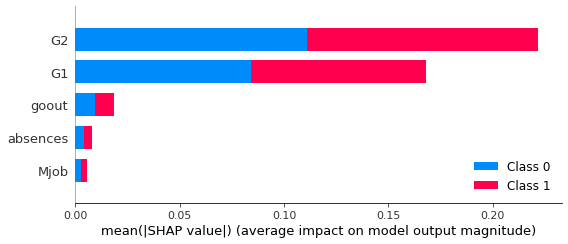

In [63]:
shap.summary_plot(shap_values, X_test)


### Results for Feature Set 1:

Optimal Hyperparameters -> n_estimators=100, criterion='gini', max_depth=3

Classification Report (weighted avg) -> precision=0.92, recall=0.92, f1=0.92



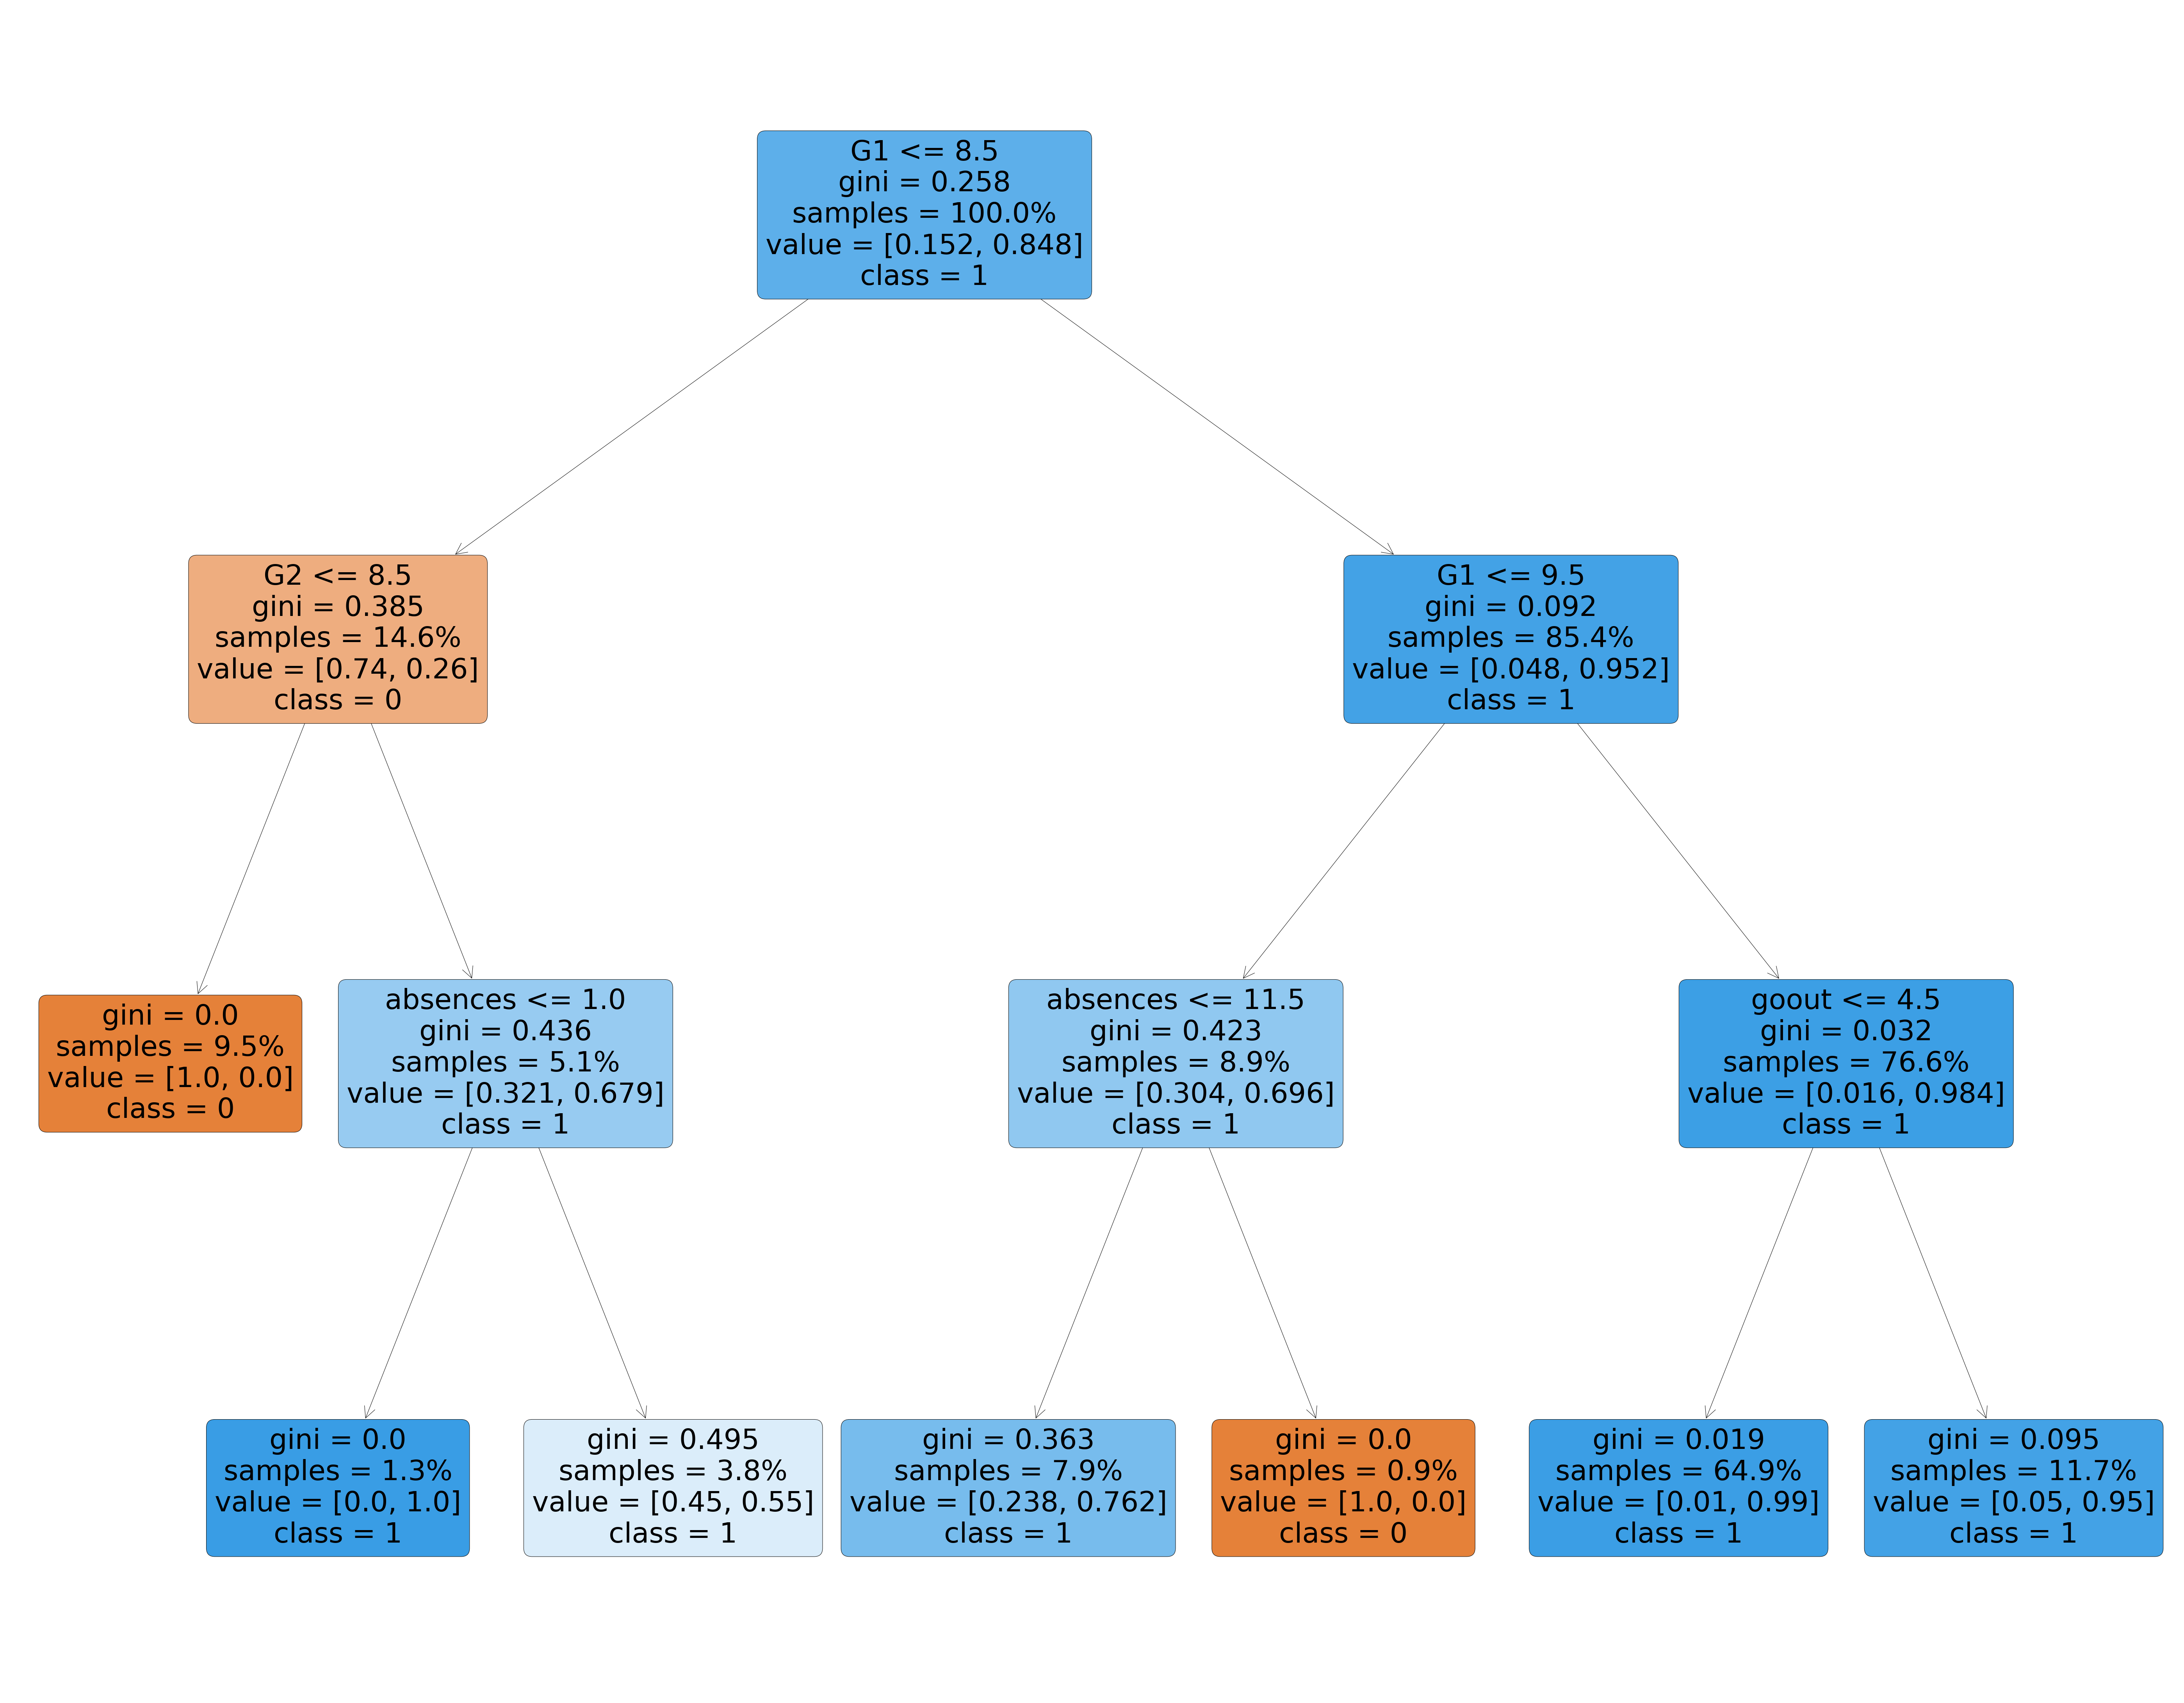

In [64]:
plt.figure(figsize=(100, 80))
plot_tree(rf.estimators_[5],
          feature_names=feature_cols,
          class_names=['0','1'],
          rounded=True, # Rounded node edges
          filled=True, # Adds color accoding to class
          proportion=True)
plt.show()

### Performing LIME On Random Forest

In [138]:

from interpret.blackbox import LimeTabular
from interpret import show

predict_fn_rf = lambda x: rf.predict_proba(X_test).astype(float)

In [143]:
lime = LimeTabular(model=rf, 
                   data=X_train, 
                   random_state=1)

In [144]:
lime_local = lime.explain_local(X_test[-30:],
                               y_test[-30:],
                               name='LIME')

In [145]:
show(lime_local)

<!-- http://127.0.0.1:7001/3190877093600/ -->

## Learned Vector Quantization

In [23]:

from sklvq import GLVQ
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

model = GLVQ(
        distance_type="squared-euclidean",
    activation_type="swish",
    activation_params={"beta": 2},
    solver_type="adam",
    solver_params={"max_runs": 20, "step_size": 0.1},
)



In [87]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.25)

In [88]:
model.fit(X2_train, y2_train)

GLVQ(activation_params={'beta': 2}, activation_type='swish',
     solver_params={'max_runs': 20, 'step_size': 0.1}, solver_type='adam')

In [89]:
y_pred_3 = model.predict(X2_test)
print(classification_report(y2_test, y_pred_3))

              precision    recall  f1-score   support

           0       1.00      0.45      0.62        11
           1       0.96      1.00      0.98       152

    accuracy                           0.96       163
   macro avg       0.98      0.73      0.80       163
weighted avg       0.96      0.96      0.96       163



Visualizing Prototypes of LVQ

Returns model prototypes / quantized vectors as values in array

In [25]:
model.get_model_params()

array([[-1.18834701, -2.02583045,  0.18969418,  0.10565937,  0.16711838],
       [ 0.07864445,  1.16935879,  0.11982348,  0.01441273, -0.12382841]])

In [26]:
model.get_params()

{'activation_params': {'beta': 2},
 'activation_type': 'swish',
 'discriminant_params': None,
 'discriminant_type': 'relative-distance',
 'distance_params': None,
 'distance_type': 'squared-euclidean',
 'force_all_finite': True,
 'prototype_init': 'class-conditional-mean',
 'prototype_n_per_class': 1,
 'random_state': None,
 'solver_params': {'max_runs': 20, 'step_size': 0.1},
 'solver_type': 'steepest-gradient-descent'}

In [27]:
model.get_prototypes()

array([[-1.18834701, -2.02583045,  0.18969418,  0.10565937,  0.16711838],
       [ 0.07864445,  1.16935879,  0.11982348,  0.01441273, -0.12382841]])

In [28]:
model.get_variables()

array([-1.18834701, -2.02583045,  0.18969418,  0.10565937,  0.16711838,
        0.07864445,  1.16935879,  0.11982348,  0.01441273, -0.12382841])

In [113]:
# # Visualizing Prototypes
# colors = ["blue", "red",]
# num_prototypes = model.prototypes_.shape[0]
# num_features = model.prototypes_.shape[1]

# fig, ax = plt.subplots(num_prototypes, 1)
# fig.suptitle("Prototype of each class")

# for i, prototype in enumerate(model.prototypes_):
#     prototype = scaler.inverse_transform(prototype)
    
#     ax[i].bar(
#         range(num_features),
#         prototype,
#         color=colors[i],
#         label=y.iloc[model.prototypes_labels_[i]],
#     )
#     ax[i].set_xticks(range(num_features))
#     if i == (num_prototypes - 1):
#         ax[i].set_xticklabels([name[:-5] for name in X[feature_cols]])
#     else:
#         ax[i].set_xticklabels([], visible=False)
#         ax[i].tick_params(
#             axis="x", which="both", bottom=False, top=False, labelbottom=False
#         )
#     ax[i].set_ylabel("cm")
#     ax[i].legend()

# Neural Networks MLP

In [24]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

mlp = MLPClassifier(hidden_layer_sizes=(6,5),
                    verbose=True,
                    activation='relu',
                    learning_rate_init=0.01)

In [48]:
mlp.fit(X2_train, y2_train)

Iteration 1, loss = 1.65314207
Iteration 2, loss = 0.78149747
Iteration 3, loss = 0.43082768
Iteration 4, loss = 0.35517737
Iteration 5, loss = 0.35570893
Iteration 6, loss = 0.35073481
Iteration 7, loss = 0.33451909
Iteration 8, loss = 0.32889937
Iteration 9, loss = 0.32928201
Iteration 10, loss = 0.31954037
Iteration 11, loss = 0.31130442
Iteration 12, loss = 0.30030222
Iteration 13, loss = 0.27950894
Iteration 14, loss = 0.27543766
Iteration 15, loss = 0.26820966
Iteration 16, loss = 0.26362260
Iteration 17, loss = 0.25969509
Iteration 18, loss = 0.25575209
Iteration 19, loss = 0.25455277
Iteration 20, loss = 0.25052103
Iteration 21, loss = 0.25079112
Iteration 22, loss = 0.24929269
Iteration 23, loss = 0.24788170
Iteration 24, loss = 0.24497310
Iteration 25, loss = 0.24347240
Iteration 26, loss = 0.24433899
Iteration 27, loss = 0.24029335
Iteration 28, loss = 0.24063247
Iteration 29, loss = 0.23843120
Iteration 30, loss = 0.23672008
Iteration 31, loss = 0.23450429
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(6, 5), learning_rate_init=0.01, verbose=True)

In [49]:
y_pred_mlp = mlp.predict(X2_test)

In [50]:
print(classification_report(y_pred_mlp, y2_test))

              precision    recall  f1-score   support

           0       0.44      0.73      0.55        15
           1       0.97      0.91      0.94       148

    accuracy                           0.89       163
   macro avg       0.71      0.82      0.74       163
weighted avg       0.92      0.89      0.90       163



## Plotting Confidence Intervals for Models & Generating Probability Distributions

In [27]:
classifier_list = [(dt, 'Decision Tree'), (rf, 'Random Forest'), (model, 'LVQ'), (mlp, 'MLP')]

C:\Users\Islam.Anwar\Anaconda3\envs\analytics\lib\site-packages\sklearn\calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
C:\Users\Islam.Anwar\Anaconda3\envs\analytics\lib\site-packages\sklearn\calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
C:\Users\Islam.Anwar\Anaconda3\envs\analytics\lib\site-packages\sklearn\calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
C:\U

Iteration 1, loss = 9.30506084
Iteration 2, loss = 7.61386692
Iteration 3, loss = 5.93315273
Iteration 4, loss = 4.31314923
Iteration 5, loss = 2.80663056
Iteration 6, loss = 1.53476896
Iteration 7, loss = 0.66310832
Iteration 8, loss = 0.23928971
Iteration 9, loss = 0.10550571
Iteration 10, loss = 0.08383296
Iteration 11, loss = 0.09252899
Iteration 12, loss = 0.10803735
Iteration 13, loss = 0.12420265
Iteration 14, loss = 0.13450970
Iteration 15, loss = 0.14025640
Iteration 16, loss = 0.14533330
Iteration 17, loss = 0.14978641
Iteration 18, loss = 0.15366299
Iteration 19, loss = 0.15700850
Iteration 20, loss = 0.15986505
Iteration 21, loss = 0.16227157
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


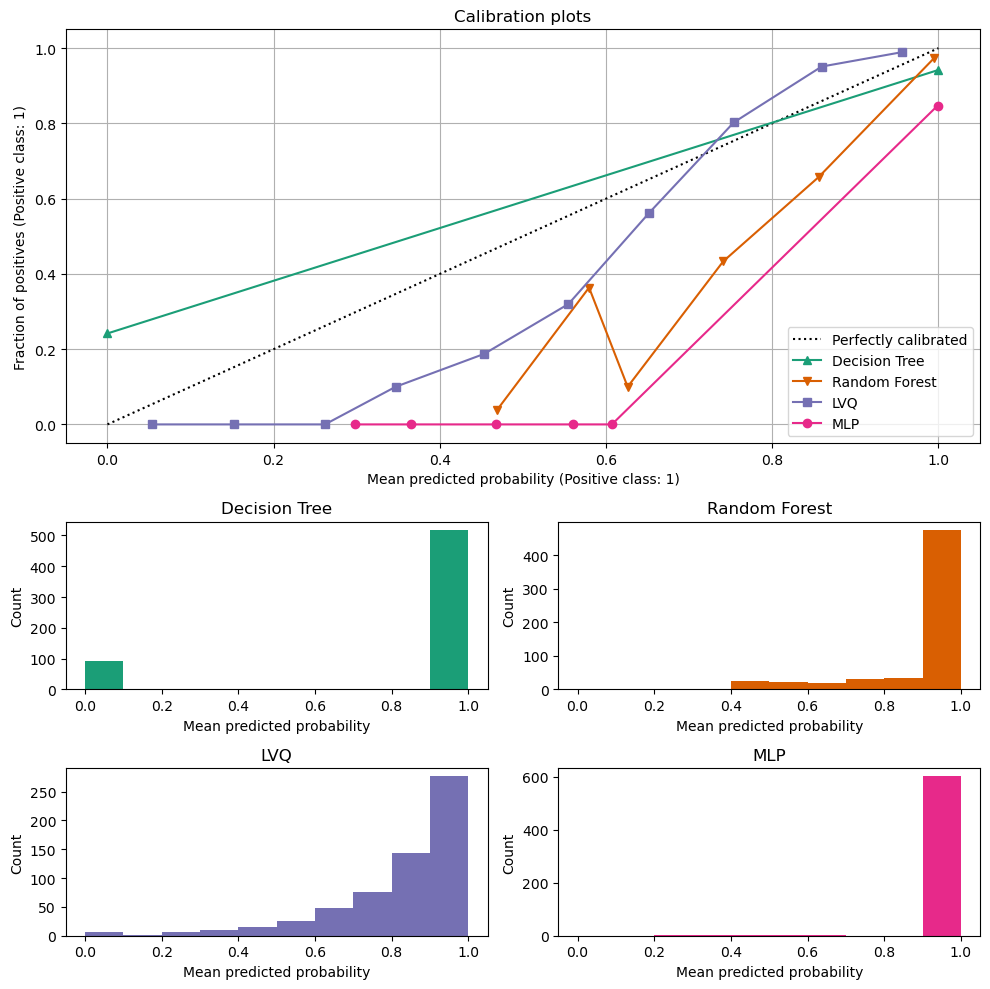

In [32]:
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(classifier_list):
    clf.fit(X_train, y_train)
    display = sklearn.calibration.CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(classifier_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()